## Part B: Using Machine Learning for Habitat Mapping
### 1. Introduction
Part A has highlighted the potential of remote sensing to aid BNG (Biodiversity Net Gain) through habitat mapping and monitoring. However, accurate ground truth data are crucial for success and reliability, which are not be freely available for my use, currently. Therefore, this study explores the use of Sentinel-2 and machine learning tomap habitats. The UK Centre of Ecology and Hydrology (UKCEH) Land Cover Map, a freely available resource, will be used for training and validation. The study aims to establish a workflow and explore machine learning techniques for detecting habitat changes, including downloading Sentinel-2 data, manipulating Satellite data, and calculating vegetation indices. The primary goal is to assess the performance of Sentinel-2 10 m resolution data and compare different machine learning algorithms to map habitats within a location affected by the High Speed 2 (HS2) development.

### 2. Methodology
#### 2.1 Study Area
The study area encompasses a small section of the HS2 railway development, the largest infrastructure project in the UK. HS2 aims to provide zero-carbon journeys between Birmingham and London, with future expansion to Manchester and Leeds, slated for completion in 2040 (HS2, 2023; Munro, 2021). Despite its commitment to BNG, the project faces scrutiny due to significant habitat loss, including ancient woodlands. A recent report suggests undervaluation of nature and overvaluation of compensation measures. This study focuses on mapping habitats within this specific section of the HS2 development (around Royal Leamingto Spa - see download_S2 notebook for further information), utilizing the UKCEH Land Cover data for training and validation.

#### 2.2 UKCEH Land Cover Data 
The Land Cover Map 2021 (LCM2021) 10 m produced by UKCEH was utilised for this study as the ground truth. The classes of each land cover are based on Biodiversity Broad Habitats. This was created by classification scenes comprising Sentinel-2 Season Composite Images combined with ten Context Layers designed to reduce spectral confusion. The LCM2021 gives an overall accuracy of 82.6 % at full thematic detail. UKCEH annual land cover maps will become an essential tool for monitoring the state and change of the UK countryside and support a wide range of environmental objectives Formal validation of LCM2021 gives an overall accuracy of 82.6 %, at full thematic detail. 

#### 2.3 Sentinel-2 Data 
The Sentinel-2 Data was downloaded using GEE (see download_S2 notebook for more detail). The Sentinel-2 data was downlaoded during the same year as the UKCEH data (2021) with the scene cloud set to a maximum of 10%. This resulted in Sentinel-2 images from February 2021 a resolution of 10 m. The Sentinel-2 data contained a total of 12 bands. The WVP: Scene-average Water Vapour map was also downloaded. 

**Table 1: Spectral Bands of Sentinel-2 Data**

| Band Name      | Band Number | Test Wavelength (nm)     |
| :---        |    :----:   |          ---: |
| Coastal Blue      | 1       | 433 - 453  |
| Blue   | 2        | 458 - 523     |
| Green   | 3        | 543 - 578      |
| Red   | 4        | 650 - 680     |
| Red-edge 1   | 5        | 698 - 713      |
| Red-edge 2   | 6        | 733 - 748     |
| Red-edge 3   | 7        | 773 - 793      |
| NIR1   | 8a        | 855 - 875      |
| NIR2   | 8        | 785 - 900    |
| Water Vapour   | 9        | 935 - 955     |
| SWIR 1   | 11        | 1565 - 1655      |
| SWIR 2   | 12        |2100 - 2280 |



#### 2.4 Pre-processing
Pre-processing steps were first performed to ensure the UKCEH Land Cover data and the Sentinel-2 data were within the same extent and at a resolution of 10 m. Various vegetation Indices were also calculated from the Sentinel-2 dataset (see pre-processing notebook). Including NDVI, EVI, NDWI, SAVI, NDBI, MNDDWI. The spectral bands, WVP and vegetation indices were set as the input features of the model, and the UKCEH Land Cover numper was set as the target variable.

The next sections of code will display the land cover of the data, the table used with the features and target variable

In [1]:
import os
import osgeo as ogr
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import pyproj
from pyproj import CRS
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import transform_geom, calculate_default_transform, reproject
from rasterio.windows import from_bounds
from rasterio.merge import merge
import osgeo.ogr
import shapely.wkt
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
from osgeo import gdal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns 

In [2]:
# Define the base data path
base_path = "C:\\Users\\bp424\\OneDrive - University of Exeter\\University\\PhD\\Term1\\Term1_Assessment\\Data"

# Change the current working directory
os.chdir(base_path)

# Construct paths and download Sentinel-2 imagery 
S2_2021_path = os.path.join(base_path, "Sentinel2", "S2_2021_w_indices.tif")
S2_2021 = rasterio.open(S2_2021_path)

S2_2023_path = os.path.join(base_path, "Sentinel2", "S2_2023_with_indices.tif")
S2_2023 = rasterio.open(S2_2023_path)

#import UKCEH Raster file 
UKCEH_path = os.path.join(base_path,"UKCEH", "UKCEH_HS2", "lcm-2021-vec", "LCM_rast.tif")
LCM_rast = rasterio.open(UKCEH_path)

LCM = gpd.read_file(os.path.join(base_path, "UKCEH", "UKCEH_HS2", "lcm-2021-vec", "lcm-2021-vec_5316125.gpkg"))

#data frame of 2021
data=pd.read_csv('combined_df.csv')

#dataframe of 2023
data_2023 = pd.read_csv('combined_df_2023.csv')

In [3]:
data.head()

,x,y,X_mode,S2_2021_w_indices_1,S2_2021_w_indices_2,S2_2021_w_indices_3,S2_2021_w_indices_4,S2_2021_w_indices_5,S2_2021_w_indices_6,S2_2021_w_indices_7,...,S2_2021_w_indices_10,S2_2021_w_indices_11,S2_2021_w_indices_12,S2_2021_w_indices_13,ndvi,S2_2021_w_indices_15,ndwi,savi,ndbi,mndwi
0,432125,253625,3,0.0453,0.0526,0.0667,0.0756,0.1011,0.1557,0.1734,...,0.1986,0.1935,0.1235,0.0985,0.424219,0.223497,-0.560935,0.219119,0.017083,-0.572531
1,432125,253635,3,0.0453,0.0528,0.0666,0.0772,0.1011,0.1557,0.1734,...,0.1986,0.1935,0.1235,0.0985,0.415594,0.218865,-0.559633,0.215520,0.017083,-0.571255
2,432125,253645,3,0.0435,0.0547,0.0659,0.0769,0.0980,0.1576,0.1735,...,0.1947,0.1839,0.1183,0.0988,0.424186,0.228179,-0.553287,0.221549,-0.016840,-0.541492
3,432125,253655,3,0.0435,0.0496,0.0659,0.0727,0.0980,0.1576,0.1735,...,0.1947,0.1839,0.1183,0.0988,0.453589,0.239941,-0.591770,0.236327,-0.025179,-0.575161
4,432125,253665,3,0.0435,0.0488,0.0620,0.0749,0.0899,0.1582,0.1757,...,0.1947,0.1735,0.1193,0.0992,0.420279,0.214303,-0.579854,0.214794,-0.028011,-0.560954


In [4]:
#rename the columns to the correct feature names
col_names = ['x', 'y', 'Land_Cover', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'WVP', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'NDBI', 'MNDWI']

data.columns = col_names

data.head()

,x,y,Land_Cover,B1,B2,B3,B4,B5,B6,B7,...,B9,B11,B12,WVP,NDVI,EVI,NDWI,SAVI,NDBI,MNDWI
0,432125,253625,3,0.0453,0.0526,0.0667,0.0756,0.1011,0.1557,0.1734,...,0.1986,0.1935,0.1235,0.0985,0.424219,0.223497,-0.560935,0.219119,0.017083,-0.572531
1,432125,253635,3,0.0453,0.0528,0.0666,0.0772,0.1011,0.1557,0.1734,...,0.1986,0.1935,0.1235,0.0985,0.415594,0.218865,-0.559633,0.215520,0.017083,-0.571255
2,432125,253645,3,0.0435,0.0547,0.0659,0.0769,0.0980,0.1576,0.1735,...,0.1947,0.1839,0.1183,0.0988,0.424186,0.228179,-0.553287,0.221549,-0.016840,-0.541492
3,432125,253655,3,0.0435,0.0496,0.0659,0.0727,0.0980,0.1576,0.1735,...,0.1947,0.1839,0.1183,0.0988,0.453589,0.239941,-0.591770,0.236327,-0.025179,-0.575161
4,432125,253665,3,0.0435,0.0488,0.0620,0.0749,0.0899,0.1582,0.1757,...,0.1947,0.1735,0.1193,0.0992,0.420279,0.214303,-0.579854,0.214794,-0.028011,-0.560954


In [5]:
#remove any missing values within the data frame and omit them if they exist 
data = data.dropna()

# Check the missing values after dropping
print(data.isnull().sum())

x             0
y             0
Land_Cover    0
B1            0
B2            0
B3            0
B4            0
B5            0
B6            0
B7            0
B8            0
B8A           0
B9            0
B11           0
B12           0
WVP           0
NDVI          0
EVI           0
NDWI          0
SAVI          0
NDBI          0
MNDWI         0
dtype: int64


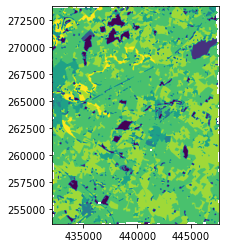

<AxesSubplot:>

In [6]:
#display rater file of the Land cover map 
show(LCM_rast)

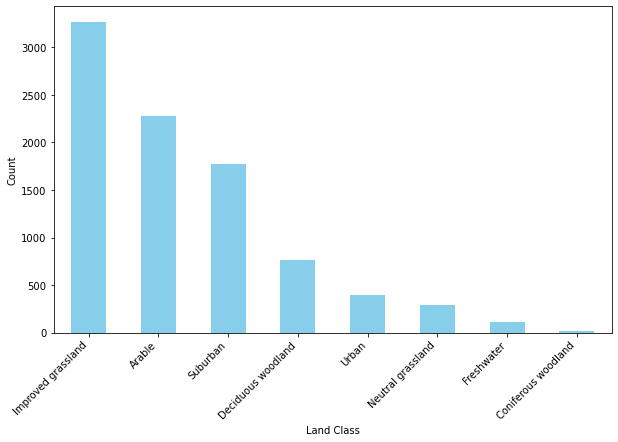

In [12]:
#plot a histogram of the number of classes within the defined area
class_mapping = {
    1: 'Deciduous woodland',
    2: 'Coniferous woodland',
    3: 'Arable',
    4: 'Improved grassland',
    5: 'Neutral grassland',
    6: 'Calcareous grassland',
    7: 'Acid grassland',
    8: 'Fen',
    9: 'Heather',
    10: 'Heather grassland',
    11: 'Bog',
    12: 'Inland rock',
    13: 'Saltwater',
    14: 'Freshwater',
    15: 'Supralittoral Rock',
    16: 'Supralittoral Sediment',
    17: 'Littoral Rock',
    18: 'Littoral Sediment',
    19: 'Saltmarsh',
    20: 'Urban',
    21: 'Suburban',
}


# Ensure '_agg' column is numeric (if not, convert it)
LCM['_mode'] = pd.to_numeric(LCM['_mode'], errors='coerce')

# Map numerical values to land class labels
LCM['land_class'] = LCM['_mode'].map(class_mapping)

# Plot histogram
plt.figure(figsize=(10, 6))
LCM['land_class'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Land Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

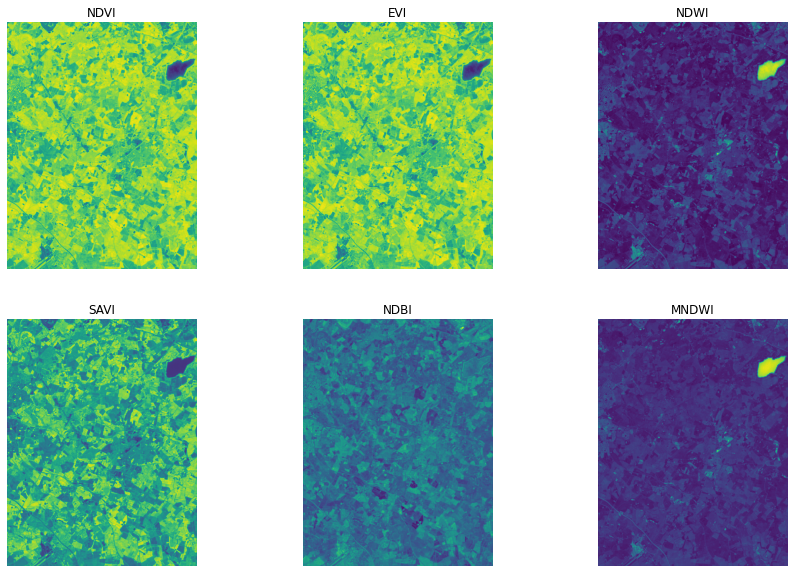

In [13]:
# Open the raster file with spectral indices and plot each of the calculated bands
with rasterio.open(S2_2021_path) as src:
    
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Read the spectral indices
    ndvi = src.read(14)  # NDVI
    evi = src.read(15)   #EVI
    ndwi = src.read(16)  # NDWI
    savi = src.read(17)  # SAVI
    ndbi = src.read(18)  # NDBI
    mndwi = src.read(19) # MNDWI

    # Create a multiplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot NDVI
    axes[0, 0].imshow(ndvi, cmap='viridis')
    axes[0, 0].set_title('NDVI')
    axes[0, 0].axis('off')
    
        # Plot EVI
    axes[0, 1].imshow(ndvi, cmap='viridis')
    axes[0, 1].set_title('EVI')
    axes[0, 1].axis('off')

    # Plot NDWI
    axes[0, 2].imshow(ndwi, cmap='viridis')
    axes[0, 2].set_title('NDWI')
    axes[0, 2].axis('off')

    # Plot SAVI
    axes[1, 0].imshow(savi, cmap='viridis')
    axes[1, 0].set_title('SAVI')
    axes[1, 0].axis('off')

    # Plot NDBI
    axes[1, 1].imshow(ndbi, cmap='viridis')
    axes[1, 1].set_title('NDBI')
    axes[1, 1].axis('off')

    # Plot MNDWI
    axes[1, 2].imshow(mndwi, cmap='viridis')
    axes[1, 2].set_title('MNDWI')
    axes[1, 2].axis('off')

    # Display the multiplot
    plt.show()

#### 2.4 Random Forest Modelling
Random Forest is an ensemble learning method that uses recursive partitioning to create multiple regression trees to make predictions (Breiman, 2001). The random characteristic of this method allows for increased stability of the model, and can enhance the robustness of the model (Zhang et al., 2022). Further to this, it is able to reduce overfitting as RF will take the average of the predicted values across the decision trees (Wang et al., 2021). Random Forest has been adopted widely for canopy height modelling and prediction, producing results of high accuracy (Csillik et al., 2020; Dube et al., 2015; Fassnacht et al., 2021; Fayad et al., 2021; Gupta and Sharma, 2023).

To detect Land Cover change, the first step will be to create a random forest model that is able to classify the land cover in 2021. This was originally completed with no hyperparameter tuning to see the initial accuracy. The train and test data was randomly split at 80:20. 

In [35]:
# Define the target variable (y) and the features
target_variable = 'Land_Cover'
features = data.drop(['x', 'y', target_variable], axis=1)
target = data[target_variable]

# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9047350492905322


This Random Forest Classifier has an accuracy of ~90%.This next section will display what features were important within the classifier to predict land cover, as well as the confusion matrix. 

In [221]:
feature_scores = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

B9       0.132736
B1       0.081620
MNDWI    0.075217
WVP      0.070706
B5       0.066848
B8A      0.062941
B6       0.056224
B12      0.053171
B11      0.050478
B7       0.042867
B8       0.038323
EVI      0.037909
B4       0.036934
SAVI     0.036899
NDWI     0.036349
NDVI     0.034424
B2       0.033181
B3       0.027017
NDBI     0.026155
dtype: float64

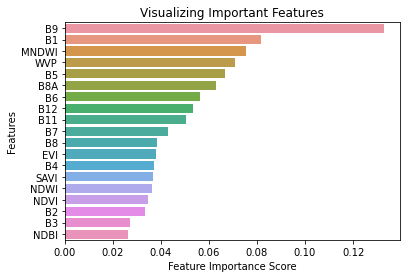

In [222]:
# Creating a seaborn bar plot
sns.barplot(x=feature_scores, y=feature_scores.index)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Add title to the graph
plt.title("Visualizing Important Features")

# Visualize the graph
plt.show()

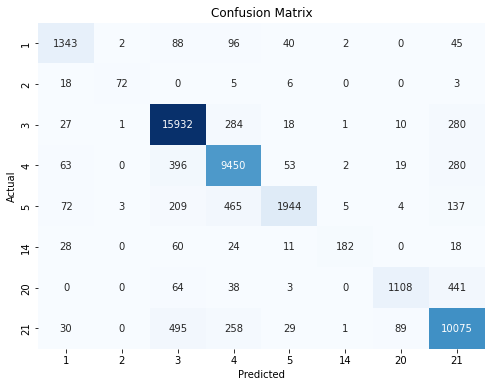

In [226]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Now to see which Land Cover had the lowest accuracy. 

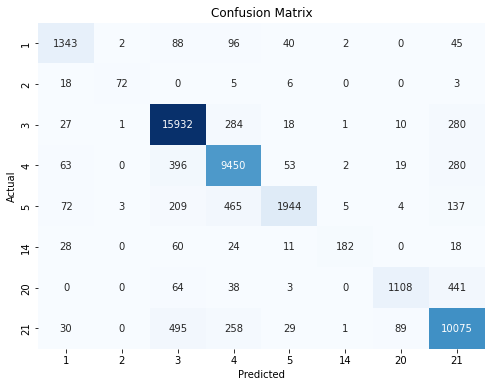

Class-wise Accuracy: {1: 0.8310643564356436, 2: 0.6923076923076923, 3: 0.9624841418473993, 4: 0.9207833966676411, 5: 0.6847481507573089, 14: 0.5634674922600619, 20: 0.6698911729141476, 21: 0.9178281862075248}
The class with the lowest accuracy: 14


In [21]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate class-wise accuracy
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Find the class with the lowest accuracy
min_accuracy_class = rf_classifier.classes_[class_accuracy.argmin()]

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(f"Class-wise Accuracy: {dict(zip(rf_classifier.classes_, class_accuracy))}")
print(f"The class with the lowest accuracy: {min_accuracy_class}")

Here we can see the land cover that was most difficult to predict is Land Cover 14 with an accuracy of only 56%. This land cover is Freshwater, which was reguarly classed as Arable. Future studies could include other indices that may be better at predicting water classes.The next step would be to introduce hyperparamter tuning to see if accuracy could be improved. This was not completed for this scenario, but an example of code and potential hyperparameters are listed below: 

The hyperparamter tuning that will be introduced includes: 

**Number of estimators:** the number of the trees in the forest. In general, increasing the number of estimators will improve the model's performance. 

**Maximum Depth:** the maximum depth of the individual trees in the forest. By controlling the depth of the trees it can help limit the complexity of each tree. 

**Minimum Sample Split:** the minimum number of samples required to split an internal model. Higher values can lead to a ore robust model by avoiding splits that are based on fewer samples. 

**Minimum Samples Leaf:** the minimum number of samples required to be at a leaf node. Higher values can result in smoother decision boundaries. 

This will be completed using a grid search over the hyperparameter grid specified below. The best hyperparameters will then be selected using cross-validation. 


In [ ]:
from sklearn.model_selection import GridSearchCV


# Sample 10% of the entire dataset for hyperparameter tuning
sample_size = int(0.1 * len(features))
features_sampled = features.sample(n=sample_size, random_state=42)
target_sampled = target.loc[features_sampled.index]

# Split the sampled data into training and testing sets
X_train_sampled, X_test, y_train_sampled, y_test = train_test_split(features_sampled, target_sampled, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier_hyper = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_classifier_hyper, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the sampled training data
grid_search.fit(X_train_sampled, y_train_sampled)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the original test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the accuracy of the best model on the original test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy}")

#### 2.5 Support Vector Machine
It is now time to test how a support vector machine compares with habitat mapping. 

Support Vector Machines (SVM) is a machine learning algorithm designed for both classification and regression tasks. It works by finding the hyperplane that best separates the data into different classes while maximizing the margin between the classes. The hyperplane is chosen to be the one that maximizes the distance between the nearest data points of the two classes, known as support vectors.

In [20]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define the target variable and the features
target_variable = 'Land_Cover'
features = data.drop(['x', 'y', target_variable], axis=1)
target = data[target_variable]

# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create an SVM classifier with a pipeline that includes feature scaling
svm_classifier = make_pipeline(StandardScaler(), SVC(random_state=42))

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8073495905614835


The SVM had an accuracy of ~81%. However, it is to be noted that this was the slowest performing model

#### 2.6 K- Nearest Neighbour (kNN)
k-Nearest Neighbors (KNN) is a simple and effective machine learning algorithm used for classification and regression tasks. It makes predictions based on the majority class or average of the k-nearest data points in the feature space. KNN is non-parametric, relying on proximity measures like Euclidean distance, and is versatile for various applications, though it can be computationally intensive with large datasets.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Define the target variable (y) and the features
target_variable = 'Land_Cover'
features = data.drop(['x', 'y', target_variable], axis=1)
target = data[target_variable]

# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3) 

# Train the classifier on the training data
knn_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.856504771143044


The accuracy of the KNN was ~86%. It is noted that other KNN weres tested (4,5,6) and 3 was the heighest performing. An elbow method could be performed along with this technique to determine the most apporopriate n's. 

#### 2.7 Light Gradient Boosting Machine (LGBM)
LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework that is designed for distributed and efficient training. It is known for its speed and high-performance, especially when dealing with large datasets

In [9]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# Define the target variable (y) and the features
target_variable = 'Land_Cover'
features = data.drop(['x', 'y', target_variable], axis=1)
target = data[target_variable]

# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train, y_train)

y_pred = lgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 177313, number of used features: 19
[LightGBM] [Info] Start training from score -3.320838
[LightGBM] [Info] Start training from score -5.958803
[LightGBM] [Info] Start training from score -0.991570
[LightGBM] [Info] Start training from score -1.473878
[LightGBM] [Info] Start training from score -2.718670
[LightGBM] [Info] Start training from score -4.938900
[LightGBM] [Info] Start training from score -3.311204
[LightGBM] [Info] Start training from score -1.379645
Accuracy: 0.8689796747050463
              precision    recall  f1-score   support

           1       0.77      0.78      0.78      1616
           2       0.46      0.69      0.55       104
           3       0.91      0.94      0.92     16553
           4       0.84      0.8

The accuracy of the Light Gradient Boosting Model (LGBM) was ~87%. However it is to be noted that this ML technique is very efficient and performed very quickly

### 3. Discussion 
In this study, we explored the application of machine learning, specifically focusing on habitat mapping within an area affected by the High Speed 2 (HS2) development. Leveraging Sentinel-2 satellite data and the UK Centre of Ecology and Hydrology (UKCEH) Land Cover Map, we implemented a workflow that included data preprocessing, and comparison of four machine learning techniques - random forest, support vector machine, light gradient boosting modelling and k- nearest neighbour. 

The Random Forest model exhibited promising performance, achieving an accuracy of approximately 90% in classifying land cover types. The identification of influential features highlighted the significance of spectral bands, water vapor content, and various vegetation indices in predicting habitat changes. Nevertheless, the model demonstrated varying accuracies across different land cover classes, emphasizing the importance of addressing specific challenges, particularly in distinguishing certain classes like Freshwater.

To further enhance the modelling process, the concept of hyperparameter tuning was introduced. Although this step wasn't implemented in this study, it presents a valuable avenue for future research to fine-tune the model and potentially improve predictive capabilities. 

Additionally, we explored alternative machine learning algorithms, such as Support Vector Machines (SVM), k-Nearest Neighbours (kNN), and Light Gradient Boosting Machine (LGBM). Each algorithm demonstrated unique characteristics, and their performances were evaluated, with the Random Forest and kNN standing out for their notable accuracy.

Overall, the study provides valuable insights into the integration of machine learning and satellite data for habitat mapping. Future research directions may include expanding the dataset, incorporating additional indices, and refining models to address class-specific challenges. This work contributes to the broader field of environmental monitoring, emphasizing the potential of machine learning in biodiversity and habitat assessment, which is crucial for informed decision-making in large-scale development projects within Biodiversity Net Gain.